# Wildfire Impact Analysis on Larimer County, Colorado 

In [30]:
import sys, json
from Reader import Reader
import time
import matplotlib.pyplot as plt
import numpy as np
import math 
from shapely.geometry import Polygon, Point
from math import radians, sin, cos, sqrt, atan2
import re
from datetime import datetime
from collections import Counter

## Loading in USGS Fire Data
Data was taken from the [USGS Website](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81). This data is the combined fire history for all US states since the late 1800s.

In [31]:
WF = 'USGS_Wildland_Fire_Combined_Dataset.json'
wf_reader = Reader(WF)
header = wf_reader.header()
print(header)

{'displayFieldName': '', 'fieldAliases': {'OBJECTID': 'OBJECTID', 'USGS_Assigned_ID': 'USGS Assigned ID', 'Assigned_Fire_Type': 'Assigned Fire Type', 'Fire_Year': 'Fire Year', 'Fire_Polygon_Tier': 'Fire Polygon Tier', 'Fire_Attribute_Tiers': 'Fire Attribute Tiers', 'GIS_Acres': 'GIS_Acres', 'GIS_Hectares': 'GIS_Hectares', 'Source_Datasets': 'Source Datasets', 'Listed_Fire_Types': 'Listed Fire Types', 'Listed_Fire_Names': 'Listed Fire Names', 'Listed_Fire_Codes': 'Listed Fire Codes', 'Listed_Fire_IDs': 'Listed Fire IDs', 'Listed_Fire_IRWIN_IDs': 'Listed Fire IRWIN IDs', 'Listed_Fire_Dates': 'Listed Fire Dates', 'Listed_Fire_Causes': 'Listed Fire Causes', 'Listed_Fire_Cause_Class': 'Listed Fire Cause Class', 'Listed_Rx_Reported_Acres': 'Listed Rx Reported Acres', 'Listed_Map_Digitize_Methods': 'Listed Map Digitize Methods', 'Listed_Notes': 'Listed Notes', 'Processing_Notes': 'Processing Notes', 'Wildfire_Notice': 'Wildfire Notice', 'Prescribed_Burn_Notice': 'Prescribed Burn Notice', 'Wil

In [32]:
found_count = 0
feature_count = 0
assigned_city = (40.3955, -105.0746)  # Latitude, Longitude
feature_list = []

# distance function
def haversine(coord1, coord2):
    R = 3958.8  # Earth radius in miles
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c


## Grabbing needed data from USGS
For our analysis, we only want fires that fit this criteria: must be a wildfire, must have occured between 1963 and 2023, and must be within 1250 miles of our city (Larimer County). Distance from said fire is calculated by the centriod of the fire, not the most outer ring.  

In [34]:
import time
wf_reader = Reader(WF)
feature = wf_reader.next()
feature_count = 0
found_count = 0
while feature:
    feature_count += 1
    
    fire_year = feature['attributes']['Fire_Year']
    fire_type = feature['attributes']['Listed_Fire_Types'].lower()
    wf = 'wildfire' in fire_type
    if 1963 <= fire_year <= 2023 and wf:
        # Filter by Distance
        geometry = feature.get('geometry', {})
        if 'rings' in geometry:
            rings = geometry['rings']
            fire_polygon = Polygon(rings[0])
            fire_centroid = fire_polygon.centroid
            distance = haversine((fire_centroid.y, fire_centroid.x), assigned_city)

            if distance <= 1250:
                found_count += 1
                if found_count % 100 == 0:
                    print(found_count)
                feature_list.append(feature)  # Storing the filtered feature
                
    feature = wf_reader.next()

print(f"Total Features: {feature_count}")
print(f"Features meeting criteria: {found_count}")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
Total Features: 135061
Features meeting criteria: 1729


In [ ]:
# saving data to a json file
with open('data/filtered_features_final.json', 'w') as f:
    json.dump(feature_list, f)

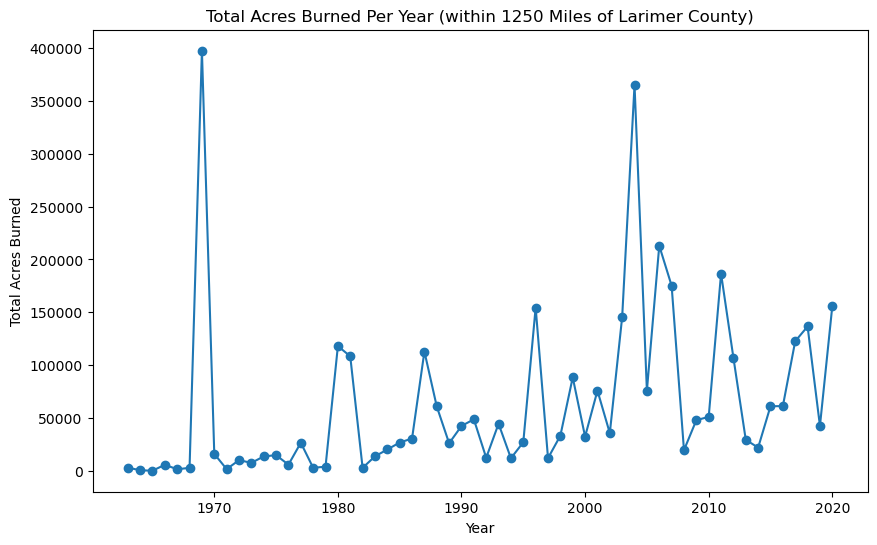

In [7]:
distance_acres_data = {}  
year_acres_data = {}  

# go through each fire record 
for feature in feature_list:
    attributes = feature['attributes']
    polygon = feature['geometry']['rings'][0]
    polygon = Polygon(polygon)
    area = polygon.area
    acres_burned = attributes['GIS_Acres']
    
    # update year_acres_data
    fire_year = attributes['Fire_Year']
    if fire_year not in year_acres_data:
        year_acres_data[fire_year] = 0
    year_acres_data[fire_year] += acres_burned


sorted_years = sorted(list(year_acres_data.keys()))

acres_by_year = [year_acres_data[year] for year in sorted_years]

sorted_years, acres_by_year

plt.figure(figsize=(10, 6))
plt.plot(list(sorted_years), list(acres_by_year), marker='o')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned Per Year (within 1250 Miles of Larimer County)')
plt.show()

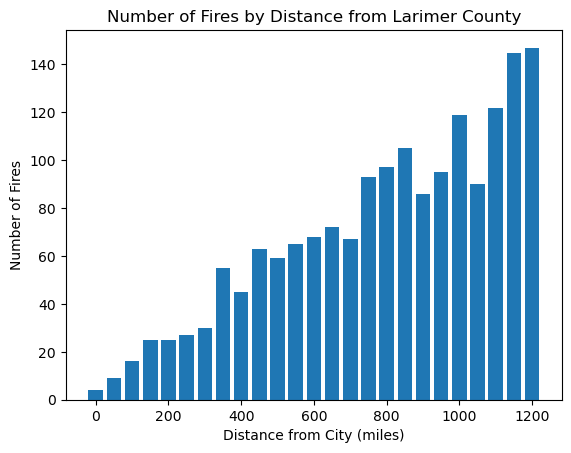

In [8]:
distances = []

# go through each feature 
for feature in feature_list:
    geometry = feature.get('geometry', {})
    rings = geometry['rings']
    fire_polygon = Polygon(rings[0])
    fire_centroid = fire_polygon.centroid
    distance = haversine((fire_centroid.y, fire_centroid.x), assigned_city)
    # add to list
    distances.append(distance)

# buckets for every 50 miles
buckets = [int(d // 50 * 50) for d in distances]

# count fires in each bucket
bucket_counts = Counter(buckets)

# create the histogram
plt.bar(bucket_counts.keys(), bucket_counts.values(), width=40)
plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Distance from Larimer County')
plt.show()

## Making Smoke Severity Estimate 
This smoke severity estimate should represent how severe the wildfire smoke will be in our County. Our estimate is calcuated by dividing the total area of the fire by the square root of the distance from our County. 

In [9]:
from collections import defaultdict

# dictionary to hold the annual smoke estimates
annual_smoke_estimate = defaultdict(float)

for feature in feature_list:
    fire_year = feature['attributes']['Fire_Year']
    fire_miles = feature['attributes']['GIS_Acres'] * 0.0015625 # converting acres to miles
    
    geometry = feature.get('geometry', {})
    if 'rings' in geometry:
        rings = geometry['rings']
        fire_polygon = Polygon(rings[0])
        fire_centroid = fire_polygon.centroid
        distance = haversine((fire_centroid.y, fire_centroid.x), assigned_city)
        
        # formula to estimate smoke for this particular fire
        if distance > 0:  # avoid division by zero
            smoke_estimate = fire_miles / (distance ** 2) 
            
            # add the smoke estimates annually
            annual_smoke_estimate[fire_year] += smoke_estimate

annual_smoke_estimate

defaultdict(float,
            {1963: 3.497530252090713e-05,
             1964: 1.295660571263292e-06,
             1965: 8.849890931835867e-07,
             1966: 0.00011575063307475918,
             1967: 1.887394808629106e-06,
             1968: 6.389582626027967e-06,
             1969: 0.0010422633332775365,
             1970: 4.433964375412686e-05,
             1971: 9.789628907146198e-06,
             1972: 4.6900769593861106e-05,
             1973: 5.299494344631717e-05,
             1974: 2.6645403324079792e-05,
             1975: 0.0001534536406304937,
             1976: 1.695491641394431e-05,
             1977: 8.341978319647279e-05,
             1978: 1.083233712637237e-05,
             1979: 6.28079798190887e-06,
             1980: 0.00014902708238568587,
             1981: 0.0001665274865884365,
             1982: 3.638683212811407e-06,
             1983: 5.975051033387005e-05,
             1984: 9.222110912757886e-05,
             1985: 6.84968768856268e-05,
             

## Using AQI data from EPA
In the file `EPA_AQI_DATA_LOAD.ipynb` we show how we grabbed this data. This section focuses on formating it, and reducing it into usable data. This section below combines each type of AQI estimate into aggregate data based upon the year.

In [11]:
import numpy as np

# Load AQI and smoke data
with open('data/gaseous_aqi_data.json', 'r') as f:
    gaseous_aqi_data = json.load(f)
with open('data/particulate_aqi_data.json', 'r') as f:
    particulate_aqi_data = json.load(f)
aggregated_data = {}

# loops through every year, get the pollutant type and AQI value
for year, year_data in gaseous_aqi_data.items():
    for site_id, site_data in year_data.items():
        for pollutant_id, pollutant_data in site_data['pollutant_type'].items():
            for date, measurements in pollutant_data['data'].items():
                year = date[:4]
                if year not in aggregated_data:
                    aggregated_data[year] = {}
                if pollutant_id not in aggregated_data[year]:
                    aggregated_data[year][pollutant_id] = []
                for measurement in measurements:
                    aqi_value = measurement.get('aqi', None)
                    if aqi_value is not None:
                        aggregated_data[year][pollutant_id].append(aqi_value)

for year, year_data in particulate_aqi_data.items():
    for site_id, site_data in year_data.items():
        for pollutant_id, pollutant_data in site_data['pollutant_type'].items():
            for date, measurements in pollutant_data['data'].items():
                year = date[:4]
                if year not in aggregated_data:
                    aggregated_data[year] = {}
                if pollutant_id not in aggregated_data[year]:
                    aggregated_data[year][pollutant_id] = []
                for measurement in measurements:
                    aqi_value = measurement.get('aqi', None)
                    if aqi_value is not None:
                        aggregated_data[year][pollutant_id].append(aqi_value)


# Calculate average AQI per year for each pollutant
average_aqi_per_year = defaultdict(dict)

for year, pollutants in aggregated_data.items():
    for pollutant_id, aqi_values in pollutants.items():
        average_aqi = np.mean(aqi_values)
        average_aqi_per_year[year][pollutant_id] = round(average_aqi, 2)

average_aqi_per_year

/home/peter/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/peter/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


defaultdict(dict,
            {'1975': {'42101': 81.2, '44201': 116.77},
             '1976': {'42101': 24.27},
             '1978': {'44201': 60.82},
             '1979': {'44201': 58.12},
             '1980': {'42101': 30.2, '44201': 40.35},
             '1981': {'42101': 25.96, '44201': 39.94},
             '1982': {'42101': 21.88, '44201': 37.42},
             '1983': {'42101': 22.28, '44201': 44.64},
             '1984': {'42101': 21.38, '44201': 42.02},
             '1985': {'42101': 24.79, '44201': 39.96},
             '1986': {'42101': 22.12, '44201': 39.08, '81102': 28.23},
             '1987': {'42101': 20.66, '44201': 45.6, '81102': 26.54},
             '1988': {'42101': 22.32,
              '44201': 51.44,
              '81102': 23.79,
              '88502': 17.33},
             '1989': {'42101': 21.32,
              '44201': 47.99,
              '81102': 28.25,
              '88502': 19.37},
             '1990': {'42101': 17.91,
              '44201': 41.99,
              

In [12]:
# re-naming so the data is more human-readable
pollutant_code_mapping = {
    '42101': 'CO',
    '42401': 'SO2',
    '42602': 'NO2',
    '44201': 'O2',
    '81102': 'PM10',
    '88101': 'PM2.5',
    '88502': 'Acceptable PM2.5'
}

# rename keys in the dictionary based on the mapping
def rename_keys(dictionary, mapping):
    return {mapping.get(key, key): value for key, value in dictionary.items()}

renamed_aggregated_data = {year: rename_keys(year_data, pollutant_code_mapping) for year, year_data in average_aqi_per_year.items()}

renamed_aggregated_data


{'1975': {'CO': 81.2, 'O2': 116.77},
 '1976': {'CO': 24.27},
 '1978': {'O2': 60.82},
 '1979': {'O2': 58.12},
 '1980': {'CO': 30.2, 'O2': 40.35},
 '1981': {'CO': 25.96, 'O2': 39.94},
 '1982': {'CO': 21.88, 'O2': 37.42},
 '1983': {'CO': 22.28, 'O2': 44.64},
 '1984': {'CO': 21.38, 'O2': 42.02},
 '1985': {'CO': 24.79, 'O2': 39.96},
 '1986': {'CO': 22.12, 'O2': 39.08, 'PM10': 28.23},
 '1987': {'CO': 20.66, 'O2': 45.6, 'PM10': 26.54},
 '1988': {'CO': 22.32, 'O2': 51.44, 'PM10': 23.79, 'Acceptable PM2.5': 17.33},
 '1989': {'CO': 21.32, 'O2': 47.99, 'PM10': 28.25, 'Acceptable PM2.5': 19.37},
 '1990': {'CO': 17.91, 'O2': 41.99, 'PM10': 21.67, 'Acceptable PM2.5': 20.15},
 '1991': {'CO': 12.39,
  'O2': 49.27,
  'SO2': nan,
  'PM10': 20.48,
  'Acceptable PM2.5': 16.81},
 '1992': {'CO': 13.78, 'O2': 46.29, 'PM10': 20.92, 'Acceptable PM2.5': 19.06},
 '1993': {'CO': 11.59,
  'O2': 44.91,
  'SO2': nan,
  'PM10': 17.32,
  'Acceptable PM2.5': 16.91},
 '1994': {'CO': 12.99,
  'O2': 48.76,
  'SO2': nan,
 

## Choosing our AQI estimates 
For this analysis, we are only taking into account 3 types of measurements: pm10, pm2.5, and CO. PM2.5 and PM10(sort for particulate matter < 2.5 micrometers and < 10 micrometers) best represent the kind of matter that a wildfire produces. Wildfires also greatly produce CO (short for Carbon Monoxide). 

In [13]:
# Extract PM2.5 and pm10 data for each year
pm25_data = {}
ozone_data = {}
pm10_data = {}
co_data = {}

pm25_id = 'PM2.5'
ozone_id = 'O2' 
pm10_id = 'PM10'
co_id = 'CO'

# Extract PM2.5 data
for year, data in renamed_aggregated_data.items():
    if pm25_id in data:
        pm25_data[year] = data[pm25_id]
        
# Extract PM10 data       
for year, data in renamed_aggregated_data.items():
    if pm10_id in data:
        pm10_data[year] = data[pm10_id]
        
# Extract CO data
for year, data in renamed_aggregated_data.items():
    if co_id in data:
        co_data[year] = data[co_id]
    
comparison_data = {}
for year, estimate in annual_smoke_estimate.items():
    comparison_data[year] = {
        'estimated': estimate,
        'pm25': pm25_data.get(str(year), None),
 #       'ozone': ozone_data.get(str(year), None),
        'pm10': pm10_data.get(str(year), None),
        'CO': co_data.get(str(year), None)
    }
print(comparison_data)

{1963: {'estimated': 3.497530252090713e-05, 'pm25': None, 'pm10': None, 'CO': None}, 1964: {'estimated': 1.295660571263292e-06, 'pm25': None, 'pm10': None, 'CO': None}, 1965: {'estimated': 8.849890931835867e-07, 'pm25': None, 'pm10': None, 'CO': None}, 1966: {'estimated': 0.00011575063307475918, 'pm25': None, 'pm10': None, 'CO': None}, 1967: {'estimated': 1.887394808629106e-06, 'pm25': None, 'pm10': None, 'CO': None}, 1968: {'estimated': 6.389582626027967e-06, 'pm25': None, 'pm10': None, 'CO': None}, 1969: {'estimated': 0.0010422633332775365, 'pm25': None, 'pm10': None, 'CO': None}, 1970: {'estimated': 4.433964375412686e-05, 'pm25': None, 'pm10': None, 'CO': None}, 1971: {'estimated': 9.789628907146198e-06, 'pm25': None, 'pm10': None, 'CO': None}, 1972: {'estimated': 4.6900769593861106e-05, 'pm25': None, 'pm10': None, 'CO': None}, 1973: {'estimated': 5.299494344631717e-05, 'pm25': None, 'pm10': None, 'CO': None}, 1974: {'estimated': 2.6645403324079792e-05, 'pm25': None, 'pm10': None, '

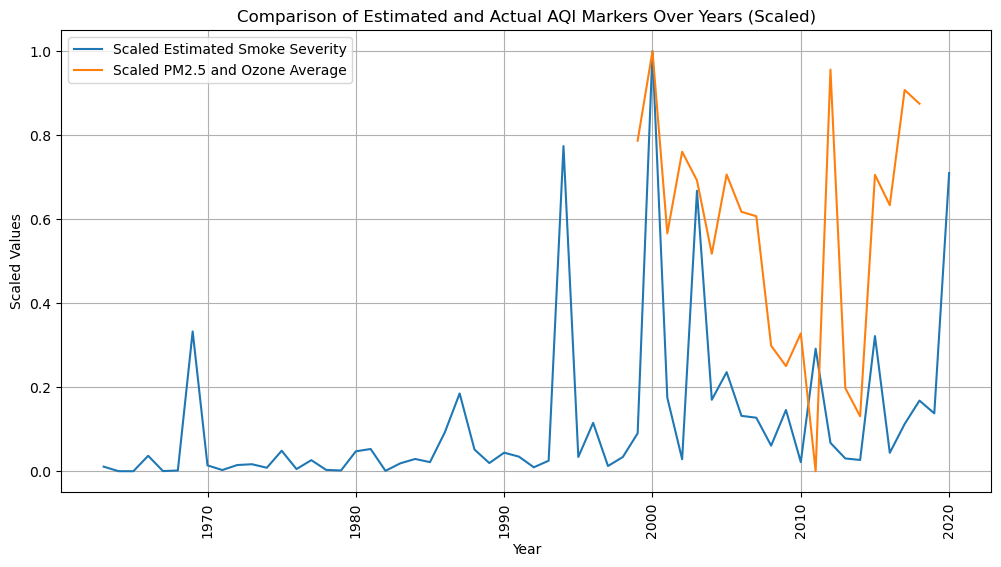

In [16]:
def minmax_scale(data):
    data = np.array(data)  # change to numpy array if it's not already
    nan_mask = np.isnan(data)
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    scaled_data[nan_mask] = np.nan  # Restore NaN values
    return scaled_data

years = sorted(comparison_data.keys(), key=int)

# initialize lists
estimated_values = []
pm25_values = []
pm10_values = []
co_values = []
avg_val = []

for year in years:
    data = comparison_data[year]
    estimated_values.append(data.get('estimated', np.nan))

    pm25 = data.get('pm25', np.nan)
    pm10 = data.get('pm10', np.nan)
    co = data.get('CO', np.nan)
    co_values.append(co)
    pm25_values.append(pm25)
    pm10_values.append(pm10)

    if pm25 is not None and pm10 is not None and co is not None:
        avg_val.append((pm25 + pm10 + co) / 3)
    else:
        avg_val.append(np.nan)

scaled_estimated_values = minmax_scale(np.array(estimated_values))
scaled_avg_val = minmax_scale(np.array(avg_val))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(years, scaled_estimated_values, label='Scaled Estimated Smoke Severity')
plt.plot(years, scaled_avg_val, label='Scaled PM2.5 and Ozone Average')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Scaled Values')
plt.title('Comparison of Estimated and Actual AQI Markers Over Years (Scaled)')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Remove null values from both lists while keeping pairs intact
filtered_estimated_values, filtered_avg_val = [], []
for est, avg in zip(estimated_values, avg_val):
    if np.isnan(est) or np.isnan(avg):
        continue
    filtered_estimated_values.append(est)
    filtered_avg_val.append(avg)

# get the correlation
correlation = np.corrcoef(filtered_estimated_values, filtered_avg_val)[0, 1]
correlation


0.33961113237516993

## Model Making Section
We are first turning all our data into a dataframe. This section of code was made with the help of ChatGPT, in particular the portion for calculating the distance from the fire to our County. The question to the AI went as such "How do I calculate the distance from one coordinate to a ring (given in coordinates) in python?".

In [18]:
import pandas as pd

km_to_miles = 0.621371

aqi_averages = {}
index = 0
year = 1963
aqi_averages = {year + i: val for i, val in enumerate(avg_val) if val is not None}


def calculate_centroid(rings):
    # Create a Polygon from rings
    polygon = Polygon(rings[0])  # assuming the first ring is the outer boundary
    # Return the centroid of the polygon
    return polygon.centroid.x, polygon.centroid.y

# Function to calculate the Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in km
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    # Calculate the distance
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Coordinates for Larimer County, Colorado
larimer_county_coords = (40.3955, -105.0746)

def process_feature(feature):
    # Calculate the centroid of the fire's geometry
    centroid = calculate_centroid(feature['geometry_rings'])
    # Calculate the distance from the centroid of the fire to Larimer County in miles
    distance_miles = haversine_distance(larimer_county_coords[0], larimer_county_coords[1], centroid[1], centroid[0]) * km_to_miles
    return distance_miles
df_features = pd.json_normalize(feature_list, sep='_')
# Count the number of rows for each year to get the total number of fires per year
df_features['Distance_to_Larimer_Miles'] = df_features.apply(process_feature, axis=1)
columns_to_remove = [
    'geometry_rings', 'attributes_Wildfire_Notice', 
    'attributes_Processing_Notes', 'attributes_Listed_Notes', 
    'attributes_Listed_Fire_Names'
]

total_fires_per_year_dict = df_features['attributes_Fire_Year'].value_counts().to_dict()

# Drop the specified columns
df_features_cleaned = df_features.drop(columns=columns_to_remove)

for col in ['attributes_Fire_Polygon_Tier', 'attributes_GIS_Acres', 'attributes_GIS_Hectares', 
            'attributes_Circleness_Scale', 'attributes_Shape_Length', 'attributes_Shape_Area']:
    df_features[col] = np.abs(np.random.randn(len(df_features))) * 100  # Absolute value for mock positive areas and lengths

df_features_cleaned = df_features.drop(columns=['geometry_rings'])
df_features_cleaned.head()

,attributes_OBJECTID,attributes_USGS_Assigned_ID,attributes_Assigned_Fire_Type,attributes_Fire_Year,attributes_Fire_Polygon_Tier,attributes_Fire_Attribute_Tiers,attributes_GIS_Acres,attributes_GIS_Hectares,attributes_Source_Datasets,attributes_Listed_Fire_Types,...,attributes_Wildfire_Notice,attributes_Prescribed_Burn_Notice,attributes_Wildfire_and_Rx_Flag,attributes_Overlap_Within_1_or_2_Flag,attributes_Circleness_Scale,attributes_Circle_Flag,attributes_Exclude_From_Summary_Rasters,attributes_Shape_Length,attributes_Shape_Area,Distance_to_Larimer_Miles
0,14315,14315,Wildfire,1963,49.946978,"1 (1), 3 (3)",25.313222,6.317103,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,186.352240,NaN,No,20.955412,71.541117,897.992727
1,14342,14342,Wildfire,1963,113.410465,"1 (2), 3 (3)",38.982416,243.489871,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,"Caution, this Wildfire in 1963 overlaps with a...",17.284828,NaN,No,19.534859,77.538190,183.205492
2,14447,14447,Wildfire,1963,72.144932,"1 (1), 3 (1)",155.283475,129.941226,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,124.032442,1.0,Yes,177.601393,150.780530,1249.852675
3,14531,14531,Wildfire,1963,88.205462,"1 (1), 3 (1)",97.077638,73.618656,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,176.564746,1.0,No,63.601723,194.475617,597.380080
4,14577,14577,Wildfire,1963,225.362850,"1 (1), 3 (1)",57.839084,207.111705,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,28.819636,1.0,No,31.450691,141.486136,676.525247


In [19]:
# calc the average of the specified columns per Fire_Year
# handling null values by skipping them
df_final = df_features_cleaned.groupby('attributes_Fire_Year').agg({
    'attributes_Fire_Polygon_Tier': 'mean',
    'attributes_GIS_Acres': 'mean',
    'attributes_GIS_Hectares': 'mean',
    'attributes_Circleness_Scale': 'mean',
    'attributes_Shape_Length': 'mean',
    'attributes_Shape_Area': 'mean',
    'Distance_to_Larimer_Miles': 'mean'
}).reset_index()

aqi_df = pd.DataFrame(list(aqi_averages.items()), columns=['attributes_Fire_Year', 'AQI'])
total_fires_per_year_dict_df = pd.DataFrame(list(total_fires_per_year_dict.items()), columns=['attributes_Fire_Year', 'Total_Fires'])
df_final = df_final.merge(aqi_df, on='attributes_Fire_Year', how='left')
df_final = df_final.merge(total_fires_per_year_dict_df, on='attributes_Fire_Year', how='left')
df_final.dropna(subset=['AQI'], inplace=True)

df_final 

,attributes_Fire_Year,attributes_Fire_Polygon_Tier,attributes_GIS_Acres,attributes_GIS_Hectares,attributes_Circleness_Scale,attributes_Shape_Length,attributes_Shape_Area,Distance_to_Larimer_Miles,AQI,Total_Fires
36,1999,72.107168,81.691168,77.374479,81.706295,74.020674,90.930514,839.827574,18.943333,39
37,2000,78.627531,85.844443,80.466111,68.121628,66.526519,59.218997,811.059797,20.160000,64
38,2001,87.945415,71.623628,83.389649,86.063758,94.599695,77.658180,837.358547,17.683333,41
39,2002,74.401613,97.702831,68.267164,88.020210,85.588259,80.154075,854.381421,18.793333,36
40,2003,84.026497,73.955382,65.309686,82.249682,75.778137,90.219501,781.448667,18.403333,39
41,2004,66.465542,75.898879,85.352941,79.722629,106.478479,74.607582,766.528095,17.406667,31
42,2005,88.214657,84.316328,93.471593,84.794409,87.294089,100.554642,818.816120,18.483333,44
43,2006,79.296687,78.727351,82.034161,76.753870,90.534752,85.765032,836.054434,17.976667,64
44,2007,87.797997,80.927953,97.163867,75.410473,91.493698,87.378523,803.319717,17.916667,60
45,2008,80.159286,81.861336,88.328348,81.017446,88.726146,94.229531,775.737508,16.156667,40


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# prep the data for linear regression
X = df_final.drop(columns=['AQI', 'attributes_Fire_Year'])  # Features
y = df_final['AQI']  # Target variable

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

# Predicting the AQI for the test set
y_pred = linear_model.predict(X_test)

# get the performance metrics for the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

rmse, r2

(1.724742140746697, 0.1110234078604646)

## Future Predictions
We are predicting the AQI for the next 25 years, we are also adding some noise into the data, due to how sparatic fire season is. 

In [28]:
ci = 1.96 * rmse  # 95% confidence interval


# mean and standard deviation for each feature
feature_means = X_train.mean()
feature_stds = X_train.std()

# random noise
np.random.seed(60)  
ff_values = []

for x in future_years:
    simulated_features = feature_means + np.random.randn(*feature_means.shape) * feature_stds
    ff_values.append(simulated_features)

ff_values = np.array(ff_values)

# predict the AQI for the next 25 years 
future_predictions_with_variability = linear_model.predict(ff_values)

future_aqi_with_variability_df = pd.DataFrame({
    'Year': future_years,
    'Predicted_AQI': future_predictions_with_variability,
    'Lower_CI': future_predictions_with_variability - ci,
    'Upper_CI': future_predictions_with_variability + ci
})

future_aqi_with_variability_df 


/home/peter/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Year,Predicted_AQI,Lower_CI,Upper_CI
0,2024,18.285157,14.904662,21.665652
1,2025,15.952157,12.571663,19.332652
2,2026,18.774499,15.394004,22.154993
3,2027,18.803886,15.423391,22.184380
4,2028,17.291140,13.910646,20.671635
5,2029,18.181554,14.801060,21.562049
6,2030,17.050738,13.670243,20.431232
7,2031,15.171102,11.790608,18.551597
8,2032,18.825253,15.444758,22.205747
9,2033,17.314885,13.934390,20.695379
